# Stock NeurIPS2018 Part 3. Backtest

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.config import INDICATORS, TRAINED_MODEL_DIR

# Part 2. Backtesting

To backtest the agents, upload trade_data.csv in the same directory of this notebook. For Colab users, just upload trade_data.csv to the default directory.

In [3]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']

trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

Then, upload the trained agent to the same directory, and set the corresponding variable to True.

In [4]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

Load the agents

In [5]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + '/agent_a2c') if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + '/agent_ddpg') if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + '/agent_ppo') if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + '/agent_td3') if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + '/agent_sac') if if_using_sac else None

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [6]:
stock_dimension  = len(trade.tic.unique())
train.tic.unique()

array(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS',
       'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
       'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT'],
      dtype=object)

In [7]:
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [8]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [9]:
e_trade_gym = StockTradingEnv(df=trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [10]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment=e_trade_gym
) if if_using_a2c else (None, None)

df_account_value_a2c


hit end!


,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.002789e+06
2,2020-07-06,1.004168e+06
3,2020-07-07,1.002402e+06
4,2020-07-08,9.992546e+05
...,...,...
330,2021-10-21,1.294594e+06
331,2021-10-22,1.298328e+06
332,2021-10-25,1.308043e+06
333,2021-10-26,1.306283e+06


In [11]:
df_actions_a2c

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,100,0,0,0,0,0,0,25,100,...,48,0,0,0,0,100,0,0,100,100
2020-07-02,0,100,0,0,0,0,0,0,25,100,...,48,0,0,0,0,100,0,0,100,100
2020-07-06,0,100,0,0,0,0,0,0,25,100,...,48,0,0,0,0,100,0,0,100,100
2020-07-07,0,100,0,0,0,0,0,0,25,100,...,48,0,0,0,0,100,0,0,100,100
2020-07-08,0,100,0,0,0,0,0,0,25,100,...,48,0,0,0,0,100,0,0,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment=e_trade_gym 
) if if_using_ppo else (None, None)

df_account_value_ddpg

hit end!


,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.001044e+06
2,2020-07-06,1.002681e+06
3,2020-07-07,1.000264e+06
4,2020-07-08,9.946787e+05
...,...,...
330,2021-10-21,1.269517e+06
331,2021-10-22,1.268324e+06
332,2021-10-25,1.272182e+06
333,2021-10-26,1.271517e+06


In [13]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment=e_trade_gym
) if if_using_ppo else (None, None)

df_account_value_ppo

hit end!


,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.000955e+06
2,2020-07-06,1.001562e+06
3,2020-07-07,1.001377e+06
4,2020-07-08,9.988698e+05
...,...,...
330,2021-10-21,1.197723e+06
331,2021-10-22,1.194114e+06
332,2021-10-25,1.204759e+06
333,2021-10-26,1.211173e+06


In [14]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment=e_trade_gym
) if if_using_td3 else (None, None)

df_account_value_td3

hit end!


,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.002858e+06
2,2020-07-06,1.004728e+06
3,2020-07-07,1.001989e+06
4,2020-07-08,9.956324e+05
...,...,...
330,2021-10-21,1.348698e+06
331,2021-10-22,1.355824e+06
332,2021-10-25,1.359790e+06
333,2021-10-26,1.363458e+06


In [15]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment=e_trade_gym
) if if_using_sac else (None, None)

df_account_value_sac

hit end!


,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.002834e+06
2,2020-07-06,1.004299e+06
3,2020-07-07,9.998567e+05
4,2020-07-08,9.918924e+05
...,...,...
330,2021-10-21,1.315978e+06
331,2021-10-22,1.322055e+06
332,2021-10-25,1.328024e+06
333,2021-10-26,1.334424e+06


# Part 3: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [16]:
def process_df_for_mvo(df):
    df = df.sort_values(['date','tic'], ignore_index=True)[['date','tic','close']]
    fst = df
    fst = fst.iloc[0:stock_dimension, :]
    tic = fst['tic'].tolist()
    
    mvo = pd.DataFrame()
    for k in range(len(tic)):
        mvo[tic[k]] = 0
        
    for i in range(df.shape[0]//stock_dimension):
        n = df
        n = n.iloc[i * stock_dimension:(i + 1) * stock_dimension, :]
        date = n['date'][i*stock_dimension]
        mvo.loc[date] = n['close'].tolist()
    
    return mvo

### Helper functions for mean returns and variance-covariance matrix

In [17]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
    import numpy as np
    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns): # j: Assets 
        for i in range(Rows-1): # i: Daily Prices 
            StockReturn[i, j] = ((StockPrice[i+1,j]-StockPrice[i,j])/StockPrice[i,j])*100
    
    return StockReturn

### Calculate the weights for mean-variance

In [18]:
StockData = process_df_for_mvo(train)
StockData

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2009-01-02,3.067143,58.590000,18.570000,42.799999,44.910000,8.025000,16.410000,74.230003,22.760000,84.019997,...,29.064884,19.530001,12.737500,61.689999,45.259998,26.700001,13.230000,32.000774,24.650000,18.660000
2009-01-05,3.327500,59.220001,19.200001,45.500000,46.900002,8.382500,16.850000,76.160004,23.510000,85.809998,...,30.009542,20.200001,13.155000,62.320000,44.759998,27.400000,13.250000,31.606859,25.430000,18.986668
2009-01-06,3.426786,60.040001,20.299999,46.849998,46.790001,8.532500,17.330000,77.559998,23.809999,90.050003,...,29.656488,20.750000,13.450000,62.500000,43.160000,27.110001,13.625000,30.650213,26.760000,18.870001
2009-01-07,3.278929,57.830002,20.530001,45.099998,45.220001,8.437500,17.370001,76.410004,23.889999,86.910004,...,28.253817,20.190001,12.902500,61.330002,42.470001,26.709999,14.172500,29.843628,26.450001,18.496668
2009-01-08,3.229643,58.060001,19.799999,44.500000,42.930000,8.072500,17.230000,73.610001,23.100000,83.519997,...,28.320610,19.629999,12.572500,60.910000,41.700001,26.100000,14.002500,29.881144,26.930000,17.103333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,91.250000,235.210007,97.650002,183.610001,124.790001,187.509995,45.290001,89.989998,115.849998,202.339996,...,73.215652,201.600006,100.940002,117.220001,114.589996,293.989990,197.020004,54.540001,42.680000,40.246666
2020-06-25,90.175003,231.500000,94.610001,169.869995,121.610001,186.139999,44.770000,87.309998,108.989998,197.860001,...,72.185112,197.800003,99.230003,116.989998,112.550003,288.279999,191.100006,53.910000,41.119999,39.919998
2020-06-26,91.102501,235.369995,95.930000,173.419998,124.330002,188.000000,45.119999,88.779999,110.949997,199.000000,...,72.853050,199.729996,98.500000,117.589996,113.260002,295.140015,193.100006,54.040001,41.869999,39.866669
2020-06-29,88.312500,233.399994,94.440002,181.000000,123.720001,183.320007,46.340000,86.910004,109.000000,191.380005,...,72.423660,195.779999,93.699997,116.510002,112.389999,288.450012,189.910004,53.310001,41.439999,39.500000


In [19]:
TradeData = process_df_for_mvo(trade)
TradeData

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2020-07-01,91.279999,235.520004,95.250000,185.880005,129.380005,188.100006,46.540001,89.279999,112.820000,198.880005,...,73.883591,203.139999,98.500000,119.650002,113.959999,295.829987,193.850006,55.090000,42.150002,39.816666
2020-07-02,91.962502,252.869995,96.769997,185.580002,128.250000,193.160004,46.070000,89.370003,115.000000,202.500000,...,74.971375,205.679993,98.779999,121.000000,115.040001,300.500000,196.000000,55.049999,41.310001,40.029999
2020-07-06,92.500000,260.029999,96.510002,184.520004,130.130005,194.440002,46.070000,89.500000,113.830002,201.339996,...,75.610687,208.830002,99.620003,121.769997,115.260002,303.000000,198.729996,55.349998,42.650002,39.933334
2020-07-07,93.852501,253.600006,95.440002,185.070007,127.739998,197.660004,46.119999,87.820000,113.629997,205.500000,...,75.381676,210.449997,99.220001,121.300003,113.589996,300.660004,196.809998,54.919998,42.770000,39.483334
2020-07-08,94.180000,253.149994,91.970001,179.050003,129.330002,198.000000,45.590000,86.389999,113.480003,199.539993,...,75.028625,210.070007,97.500000,122.150002,111.919998,297.350006,195.080002,55.110001,43.480000,42.666668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-21,148.809998,210.149994,179.580002,216.539993,201.600006,289.470001,56.040001,112.709999,170.199997,406.799988,...,81.110001,307.170013,158.449997,140.860001,158.169998,435.500000,230.699997,53.770000,48.299999,48.860001
2021-10-22,149.690002,209.699997,185.000000,214.600006,200.639999,289.000000,55.549999,112.220001,170.570007,409.989990,...,81.150002,310.399994,162.279999,139.389999,160.889999,440.839996,230.289993,53.419998,49.299999,49.033333
2021-10-25,148.679993,209.500000,186.729996,213.250000,201.279999,293.299988,55.110001,113.529999,169.899994,416.209991,...,81.029999,309.359985,163.229996,140.410004,162.000000,450.000000,233.449997,52.970001,49.500000,49.593334
2021-10-26,149.330002,208.199997,183.419998,213.190002,202.750000,295.779999,55.560001,113.980003,172.949997,416.369995,...,81.900002,311.000000,164.820007,141.619995,161.770004,450.489990,235.529999,52.700001,49.400002,50.000000


In [20]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols] = arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)
arReturns

array([[ 8.48858839,  1.07527064,  3.39257447, ..., -1.23095514,
         3.16430304,  1.75063123],
       [ 2.98379678,  1.3846668 ,  5.72915849, ..., -3.02670366,
         5.23004289, -0.61446693],
       [-4.31474137, -3.68087783,  1.13301211, ..., -2.6315814 ,
        -1.15844344, -1.97844706],
       ...,
       [ 1.02855318,  1.67170415,  1.39520102, ...,  0.24114463,
         1.82393001, -0.13359086],
       [-3.06248554, -0.83698061, -1.55321365, ..., -1.35085035,
        -1.02698905, -0.9197375 ],
       [ 1.93347107, -0.03855884, -0.29648324, ...,  3.02006519,
         1.64092743,  0.60759919]])

In [21]:
#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis=0)
meanReturns

array([0.13411368, 0.05961574, 0.07661737, 0.07577016, 0.05555031,
       0.13319328, 0.04950972, 0.01769506, 0.06724692, 0.04805574,
       0.09364335, 0.06377905, 0.02074461, 0.06154359, 0.03439356,
       0.06083684, 0.0293827 , 0.04433554, 0.04293418, 0.04177734,
       0.09201436, 0.08430108, 0.02824594, 0.04167721, 0.09862673,
       0.10624344, 0.02541918, 0.03352456, 0.03318261])

In [22]:
covReturns = np.cov(arReturns, rowvar=False)
covReturns

array([[3.44549665, 0.93997071, 1.50313253, 1.56712431, 1.74765811,
        1.86102435, 1.45961348, 1.13812029, 1.23140972, 1.61208889,
        1.26028358, 1.3619364 , 1.07336128, 1.49890033, 0.6265343 ,
        1.65803483, 0.70152082, 0.84996151, 1.01697601, 0.77909174,
        1.44226347, 1.33695522, 0.66889469, 0.84028329, 1.06599967,
        1.50525476, 0.59191611, 1.00359574, 0.62507494],
       [0.93997071, 2.36910348, 0.94636318, 0.90488666, 1.0243905 ,
        1.02012754, 0.9584212 , 0.76416912, 0.85602324, 0.99940657,
        0.87569331, 0.84280339, 0.6642566 , 0.88065518, 0.76446079,
        1.11059671, 0.59686122, 0.61274844, 0.75798568, 0.9792318 ,
        0.91242064, 0.87230583, 0.65009291, 0.71908731, 1.11160699,
        0.92578467, 0.5228571 , 0.90880022, 0.54087527],
       [1.50313253, 0.94636318, 4.12345796, 2.28881225, 2.2417294 ,
        1.79166546, 1.52209073, 1.64161165, 1.7754649 , 2.54024726,
        1.61521229, 1.84764489, 1.22748632, 1.42364093, 0.73096966,
  

In [23]:
#set precision for printing results
np.set_printoptions(precision=3, suppress=True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.134 0.06  0.077 0.076 0.056 0.133 0.05  0.018 0.067 0.048 0.094 0.064
 0.021 0.062 0.034 0.061 0.029 0.044 0.043 0.042 0.092 0.084 0.028 0.042
 0.099 0.106 0.025 0.034 0.033]
Variance-Covariance matrix of returns
 [[3.445 0.94  1.503 1.567 1.748 1.861 1.46  1.138 1.231 1.612 1.26  1.362
  1.073 1.499 0.627 1.658 0.702 0.85  1.017 0.779 1.442 1.337 0.669 0.84
  1.066 1.505 0.592 1.004 0.625]
 [0.94  2.369 0.946 0.905 1.024 1.02  0.958 0.764 0.856 0.999 0.876 0.843
  0.664 0.881 0.764 1.111 0.597 0.613 0.758 0.979 0.912 0.872 0.65  0.719
  1.112 0.926 0.523 0.909 0.541]
 [1.503 0.946 4.123 2.289 2.242 1.792 1.522 1.642 1.775 2.54  1.615 1.848
  1.227 1.424 0.731 3.041 0.903 1.135 1.39  1.03  1.405 1.623 0.698 1.48
  1.288 1.897 0.73  1.098 0.604]
 [1.567 0.905 2.289 4.874 2.201 1.896 1.508 1.72  1.791 1.985 1.733 2.037
  1.331 1.443 0.728 2.187 0.994 1.273 1.372 0.89  1.372 1.7   0.679 1.32
  1.385 1.658 0.612 1.045 0.608]
 [1.748 1.024 2.242 2

### Use PyPortfolioOpt

In [24]:
from pypfopt.efficient_frontier import EfficientFrontier
ef_mean = EfficientFrontier(meanReturns, covReturns,weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([366000.,      0.,      0.,      0.,      0., 152830.,      0.,
            0.,      0.,      0., 100460.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  26000.,
            0.,      0.,      0., 186700., 168020.,      0.,      0.,
            0.])

In [25]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4065.763,    0.   ,    0.   ,    0.   ,    0.   ,  833.088,
          0.   ,    0.   ,    0.   ,    0.   ,  406.721,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,  131.393,    0.   ,    0.   ,    0.   ,
        646.983,  877.435,    0.   ,    0.   ,    0.   ])

In [26]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=['Mean Var'])
MVO_result

,Mean Var
2020-07-01,1.017544e+06
2020-07-02,1.030707e+06
2020-07-06,1.037706e+06
2020-07-07,1.041722e+06
2020-07-08,1.039831e+06
...,...
2021-10-21,1.516413e+06
2021-10-22,1.525885e+06
2021-10-25,1.534818e+06
2021-10-26,1.544402e+06


# Part 4: DJIA index

Add DJIA index as a baseline to compare with.

In [27]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

In [42]:
df_dji = YahooDownloader(start_date=TRADE_START_DATE,
                         end_date=TRADE_END_DATE,
                         ticker_list=['dji']).fetch_data()
df_dji

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (319, 8)


,date,open,high,low,close,volume,tic,day
0,2020-07-01,25735.000000,25735.000000,25735.000000,25735.000000,0,dji,2
1,2020-07-06,26287.000000,26287.000000,26287.000000,26287.000000,0,dji,0
2,2020-07-07,25890.199219,25890.199219,25890.199219,25890.199219,0,dji,1
3,2020-07-08,26067.300781,26067.300781,26067.300781,26067.300781,0,dji,2
4,2020-07-09,25706.099609,25706.099609,25706.099609,25706.099609,0,dji,3
...,...,...,...,...,...,...,...,...
314,2021-10-22,35677.000000,35677.000000,35677.000000,35677.000000,0,dji,4
315,2021-10-25,35741.101562,35741.101562,35741.101562,35741.101562,0,dji,0
316,2021-10-26,35756.898438,35756.898438,35756.898438,35756.898438,0,dji,1
317,2021-10-27,35490.699219,35490.699219,35490.699219,35490.699219,0,dji,2


In [44]:
df_dji.to_csv('dji_trade.csv')

In [45]:
df_dji = df_dji[['date', 'close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),how='outer', left_index=True, right_index=True).set_index('date')
dji

,close
date,
2020-07-01,1.000000e+06
2020-07-06,1.021449e+06
2020-07-07,1.006031e+06
2020-07-08,1.012912e+06
2020-07-09,9.988770e+05
...,...
2021-10-22,1.386322e+06
2021-10-25,1.388813e+06
2021-10-26,1.389427e+06


# Part 5: Backtesting Results

Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [48]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None


In [49]:
result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result

,account_value
date,
2020-07-01,1.000000e+06
2020-07-02,1.002789e+06
2020-07-06,1.004168e+06
2020-07-07,1.002402e+06
2020-07-08,9.992546e+05
...,...
2021-10-21,1.294594e+06
2021-10-22,1.298328e+06
2021-10-25,1.308043e+06


In [50]:
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=['', '_drop'])
result

,account_value,account_value_drop
date,,
2020-07-01,1.000000e+06,1.000000e+06
2020-07-02,1.002789e+06,1.001044e+06
2020-07-06,1.004168e+06,1.002681e+06
2020-07-07,1.002402e+06,1.000264e+06
2020-07-08,9.992546e+05,9.946787e+05
...,...,...
2021-10-21,1.294594e+06,1.269517e+06
2021-10-22,1.298328e+06,1.268324e+06
2021-10-25,1.308043e+06,1.272182e+06


In [51]:
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result

,account_value,account_value_drop,account_value_drop
date,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06
2020-07-02,1.002789e+06,1.001044e+06,1.000955e+06
2020-07-06,1.004168e+06,1.002681e+06,1.001562e+06
2020-07-07,1.002402e+06,1.000264e+06,1.001377e+06
2020-07-08,9.992546e+05,9.946787e+05,9.988698e+05
...,...,...,...
2021-10-21,1.294594e+06,1.269517e+06,1.197723e+06
2021-10-22,1.298328e+06,1.268324e+06,1.194114e+06
2021-10-25,1.308043e+06,1.272182e+06,1.204759e+06


In [52]:
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')
result

/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/ipykernel_9710/4196934722.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


,account_value,account_value_drop,account_value_drop,account_value_drop,account_value_drop,Mean Var,close
date,,,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.017544e+06,1.000000e+06
2020-07-02,1.002789e+06,1.001044e+06,1.000955e+06,1.002858e+06,1.002834e+06,1.030707e+06,1.021449e+06
2020-07-06,1.004168e+06,1.002681e+06,1.001562e+06,1.004728e+06,1.004299e+06,1.037706e+06,1.021449e+06
2020-07-07,1.002402e+06,1.000264e+06,1.001377e+06,1.001989e+06,9.998567e+05,1.041722e+06,1.006031e+06
2020-07-08,9.992546e+05,9.946787e+05,9.988698e+05,9.956324e+05,9.918924e+05,1.039831e+06,1.012912e+06
...,...,...,...,...,...,...,...
2021-10-22,1.298328e+06,1.268324e+06,1.194114e+06,1.355824e+06,1.322055e+06,1.525885e+06,1.386322e+06
2021-10-25,1.308043e+06,1.272182e+06,1.204759e+06,1.359790e+06,1.328024e+06,1.534818e+06,1.388813e+06
2021-10-26,1.306283e+06,1.271517e+06,1.211173e+06,1.363458e+06,1.334424e+06,1.544402e+06,1.389427e+06


In [53]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('djia')
result.columns = col_name
result

,A2C,DDPG,PPO,TD3,SAC,Mean Var,djia
date,,,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.017544e+06,1.000000e+06
2020-07-02,1.002789e+06,1.001044e+06,1.000955e+06,1.002858e+06,1.002834e+06,1.030707e+06,1.021449e+06
2020-07-06,1.004168e+06,1.002681e+06,1.001562e+06,1.004728e+06,1.004299e+06,1.037706e+06,1.021449e+06
2020-07-07,1.002402e+06,1.000264e+06,1.001377e+06,1.001989e+06,9.998567e+05,1.041722e+06,1.006031e+06
2020-07-08,9.992546e+05,9.946787e+05,9.988698e+05,9.956324e+05,9.918924e+05,1.039831e+06,1.012912e+06
...,...,...,...,...,...,...,...
2021-10-22,1.298328e+06,1.268324e+06,1.194114e+06,1.355824e+06,1.322055e+06,1.525885e+06,1.386322e+06
2021-10-25,1.308043e+06,1.272182e+06,1.204759e+06,1.359790e+06,1.328024e+06,1.534818e+06,1.388813e+06
2021-10-26,1.306283e+06,1.271517e+06,1.211173e+06,1.363458e+06,1.334424e+06,1.544402e+06,1.389427e+06


Now, everything is ready, we can plot the backtest result.

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

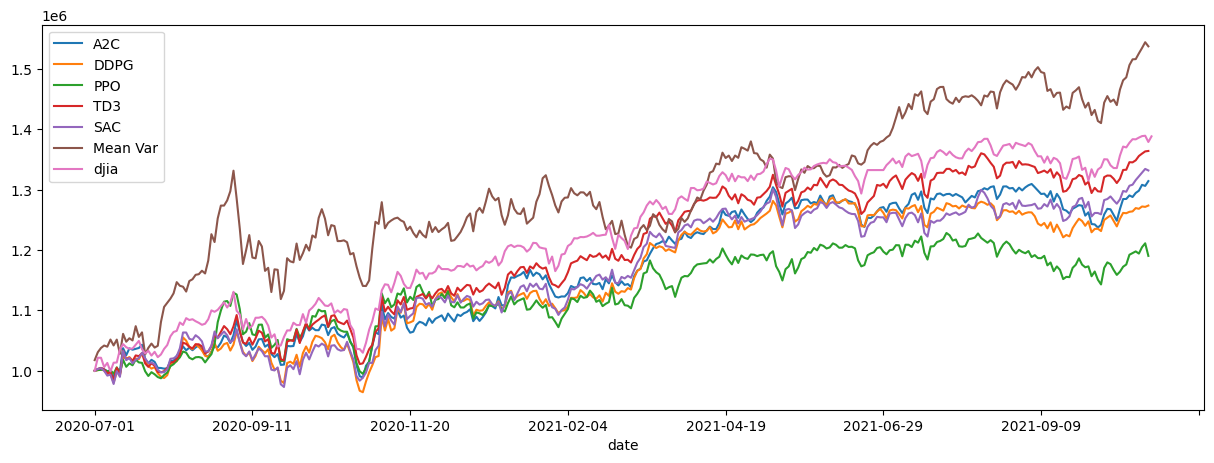

In [54]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.figure()
result.plot()